# Model v17

This model was trained and tested with images validated to contain a path (second round of validation).

Roughness metric = 1 second ahead, k-means 4, data split within sessions.

## Set-up

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.8MB 12.7MB/s 
     |████████████████████████████████| 133kB 58.6MB/s 
     |████████████████████████████████| 163kB 56.4MB/s 
     |████████████████████████████████| 102kB 14.3MB/s 
     |████████████████████████████████| 81kB 12.1MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6490 sha256=b22adf5403407efcd651299c3a66dedd5f7bc64c7d6ac34bde0fa2e00eea503a
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built subprocess32


In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 48.5MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!ls '/gdrive/My Drive/Labeling/Model/'

CompareModels.ipynb  Models.gdoc   split_within_session  v12  v15
ImageFolder.ipynb    Previous	   v10			 v13  v8
Images		     Results.gdoc  v11			 v14  v9


In [ ]:
from fastai.vision import *
import pandas as pd
import numpy as np
import os

In [ ]:
import wandb
from wandb.fastai import WandbCallback

wandb.init(project='roughness-classifier-3')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Model

#### Load data

In [ ]:
path = '/gdrive/My Drive/Labeling/Model'
folder_path = os.path.join(path, 'split_within_session', 'v17')
image_path = os.path.join(path, 'Images')
label_path = '/gdrive/My Drive/Labeling/LabelsCSV'

In [ ]:
df = pd.read_csv(os.path.join(label_path, 'split_within_session', 'labels_path_validated_split_metric_2.csv'))
df = df.filter(items=['image', 'group_4', 'dataset'])

# Categorical data
df['group_4'] = df['group_4'].astype(int).astype(str)

# Create is_valid column
df['is_valid'] = df['dataset'] == 'valid'

# Training set, filter out dataset column
train = df[df['dataset'] == 'train'].filter(items=['image', 'group_4', 'is_valid'])

# Validation set, filter out dataset column
valid = df[df['dataset'] == 'valid'].filter(items=['image', 'group_4', 'is_valid'])

#### Balance classes

In [ ]:
# Training set
group_0 = train[train['group_4'] == '0']
group_1 = train[train['group_4'] == '1']
group_2 = train[train['group_4'] == '2']
group_3 = train[train['group_4'] == '3']

print(len(group_0))
print(len(group_1))
print(len(group_2))
print(len(group_3))

2170
1790
770
213


In [ ]:
group_0 = group_0[:1200]
group_1 = group_1[:1200]

train_balanced = group_0.append(group_1).append(group_2).append(group_3)

print(len(train_balanced))
print(len(train_balanced[train_balanced['group_4'] == '0']))
print(len(train_balanced[train_balanced['group_4'] == '1']))
print(len(train_balanced[train_balanced['group_4'] == '2']))
print(len(train_balanced[train_balanced['group_4'] == '3']))

3383
1200
1200
770
213


In [ ]:
# Validation set
group_0_v = valid[valid['group_4'] == '0']
group_1_v = valid[valid['group_4'] == '1']
group_2_v = valid[valid['group_4'] == '2']
group_3_v = valid[valid['group_4'] == '3']

print(len(group_0_v))
print(len(group_1_v))
print(len(group_2_v))
print(len(group_3_v))

407
396
185
70


In [ ]:
group_0_v = group_0_v[:200]
group_1_v = group_1_v[:200]

valid_balanced = group_0_v.append(group_1_v).append(group_2_v).append(group_3_v)

print(len(valid_balanced))
print(len(valid_balanced[valid_balanced['group_4'] == '0']))
print(len(valid_balanced[valid_balanced['group_4'] == '1']))
print(len(valid_balanced[valid_balanced['group_4'] == '2']))
print(len(valid_balanced[valid_balanced['group_4'] == '3']))

655
200
200
185
70


In [ ]:
df_balanced = train_balanced.append(valid_balanced)
print(len(df_balanced))
print(len(df_balanced[df_balanced['is_valid'] == False]))
print(len(df_balanced[df_balanced['is_valid'] == True]))

4038
3383
655


In [ ]:
df_balanced.head()

,image,group_4,is_valid
0,969905035s184ms.jpg,0,False
1,970588340s260ms.jpg,0,False
5,964869288s707ms.jpg,0,False
7,969902113s258ms.jpg,0,False
8,970588196s250ms.jpg,0,False


#### DataBunch

The original image size is 3840 x 2160. We resize (squish) to a smaller image with the same aspect ratio (270 x 480, decreased by a factor of 8) [Link](https://fastai1.fast.ai/vision.transform.html#Data-augmentation-details).

In [ ]:
bs = 64
# bs = 16    # uncomment this line if you run out of memory

In [ ]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path, df=df_balanced)
        .split_from_df(col='is_valid')
        .label_from_df(cols='group_4')
        .transform(get_transforms(do_flip=False), size=(270,480))
        .databunch(bs=bs)
        .normalize())

In [ ]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

3383 3383
655 655


In [ ]:
print(data.classes)

['0', '1', '2', '3']


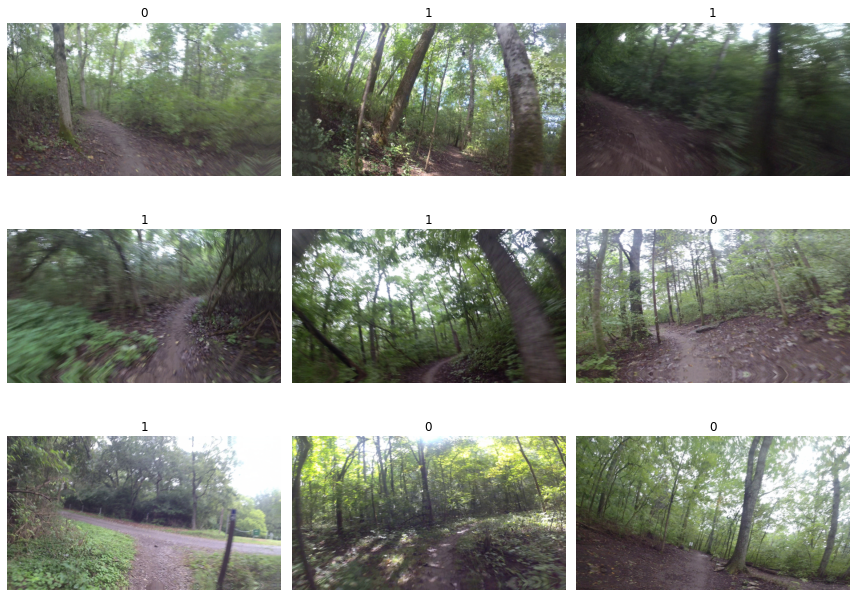

In [ ]:
data.show_batch(rows=3, figsize=(12,9))

#### ResNet50

In [ ]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy], callback_fns=WandbCallback)
# learn = cnn_learner(data, arch, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


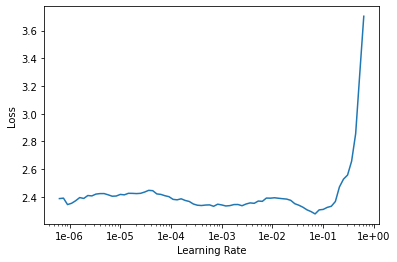

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 0.01

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,2.081763,1.766543,0.370992,14:54
1,1.574362,1.705996,0.393893,16:24
2,1.386855,1.696687,0.370992,16:30
3,1.229352,1.323383,0.435115,16:40
4,1.115703,1.250948,0.439695,16:24


Better model found at epoch 0 with valid_loss value: 1.766542911529541.
Better model found at epoch 1 with valid_loss value: 1.705996036529541.
Better model found at epoch 2 with valid_loss value: 1.6966869831085205.
Better model found at epoch 3 with valid_loss value: 1.32338285446167.
Better model found at epoch 4 with valid_loss value: 1.250948190689087.
Loaded best saved model from /content/wandb/run-20201231_190947-fyxnxhvd/files/bestmodel.pth


In [ ]:
learn.save(os.path.join(folder_path, 'v17-stage-1'))

In [ ]:
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.167017,1.375393,0.410687,16:25
1,1.141957,1.340550,0.413740,16:34


Better model found at epoch 0 with valid_loss value: 1.3753929138183594.
Better model found at epoch 1 with valid_loss value: 1.3405503034591675.
Loaded best saved model from /content/wandb/run-20201231_190947-fyxnxhvd/files/bestmodel.pth


In [ ]:
learn.load(os.path.join(folder_path, 'v17-stage-1'))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

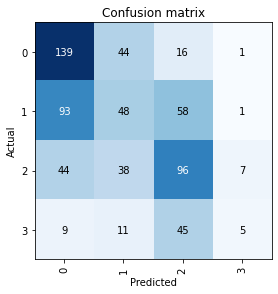

In [ ]:
interp.plot_confusion_matrix()

#### Fine-tune

In [ ]:
learn.load(os.path.join(folder_path, 'v17-stage-1'))

In [ ]:
bs = 16    # uncomment this line if you run out of memory
learn.data.batch_size = 16

In [ ]:
learn.data.batch_size

16

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


Loaded best saved model from /content/wandb/run-20201231_190947-fyxnxhvd/files/bestmodel.pth
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


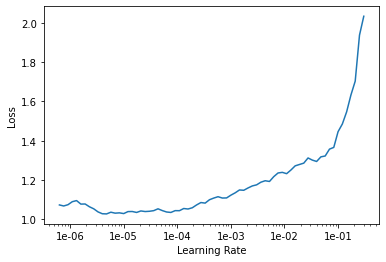

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.069508,1.245223,0.436641,16:54
1,1.080636,1.276244,0.403053,16:54
2,1.007199,1.240675,0.425954,17:10
3,1.001425,1.194185,0.454962,17:06
4,0.964967,1.203249,0.433588,16:56


Better model found at epoch 0 with valid_loss value: 1.2452232837677002.
Better model found at epoch 2 with valid_loss value: 1.2406747341156006.
Better model found at epoch 3 with valid_loss value: 1.1941850185394287.
Loaded best saved model from /content/wandb/run-20201231_190947-fyxnxhvd/files/bestmodel.pth


In [ ]:
learn.save(os.path.join(folder_path, 'v17-stage-2'))

In [ ]:
learn.freeze()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

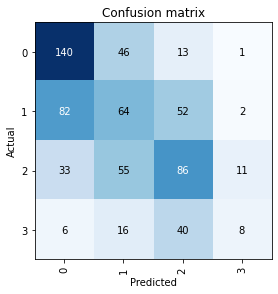

In [ ]:
interp.plot_confusion_matrix()

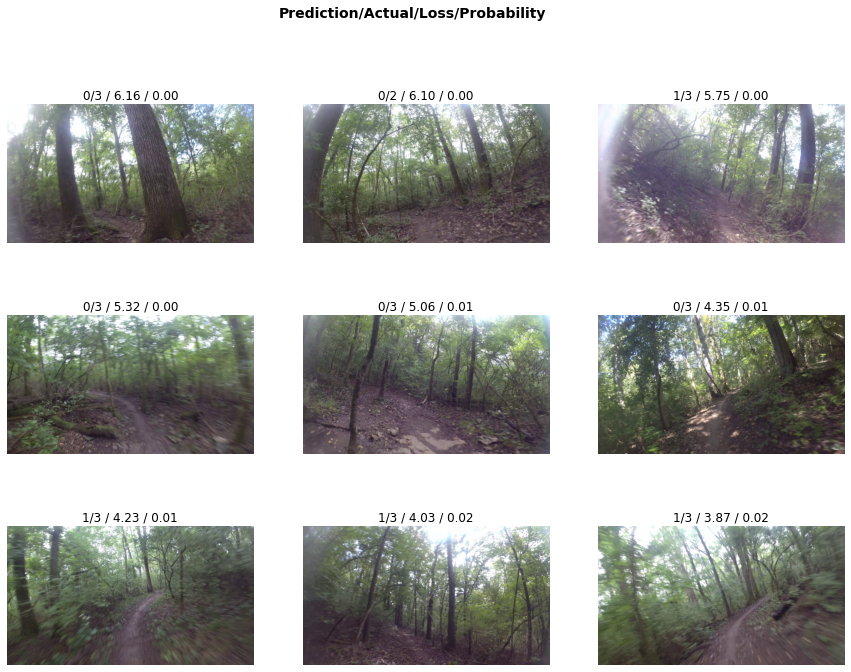

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))